### LSTM - Feature columns: Date Time + Borough || Prediction: Pickup count by Borough

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# FIX ME: Root dir as argument
root_dir = "../../data/picklerCheckpoints/"
is_compressed = True;
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import numpy as np
import pandas as pd
import nbimporter
import geopandas as gpd
import commons.utility.pickle_util as pickle
import Preprocessing.SpatialMapping as sm
import Preprocessing.Discretization as dis
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import time
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import tensorflow as tf

coord_system = {'init': 'epsg:4326'}

Importing Jupyter notebook from D:\Academics\MLRepoFeb\ML2020-Uber-Data-Analysis\commons\utility\pickle_util.ipynb
Importing Jupyter notebook from D:\Academics\MLRepoFeb\ML2020-Uber-Data-Analysis\Preprocessing\SpatialMapping.ipynb
Importing Jupyter notebook from D:\Academics\MLRepoFeb\ML2020-Uber-Data-Analysis\Preprocessing\DataEnrichment.ipynb
Importing Jupyter notebook from D:\Academics\MLRepoFeb\ML2020-Uber-Data-Analysis\Preprocessing\Discretization.ipynb


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
import keras
from keras import layers

In [5]:
data = sm.run(['apr', 'may', 'jun', 'jul', 'aug'])

Data for the month :apr Found.....
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loading file ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-apr14.p
Decompressing ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-apr14.p.pbz2..............Done
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Data for the month :may Found.....
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loading file ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-may14.p
Decompressing ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-may14.p.pbz2..............Done
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Data for the month :jun Found.....
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loading file

In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
def ljust(lst, n, fillvalue=0):
    return lst + [fillvalue] * (n - len(lst))

In [8]:
def transposeZones(df2, column):
    dftest = df2[['datetime', column, 'pickups']]
    dftest = dftest.sort_values(['datetime', column], ascending=[True, True]).set_index('datetime')
    #dftest.head(len(dftest.zone.unique())-1)
    zone_order = dftest[column].unique()
    print(zone_order)
    dftest = dftest.groupby('datetime').agg({lambda x: x.tolist()})
    a = dftest.loc[:, ['pickups']].T
    b = dftest.loc[:, [column]].T
    N = len(zone_order)
    M = np.shape(a)[1]
    acc = []
    idx = 0
    for date in a.columns:
        sub_list_start = 0
        sub_list_end = len(a[date])
        row = a[date].values[0]
        acc.append(ljust(row, N))
       # zeros[idx][sub_list_start : sub_list_end+1] = a[date]
        idx = idx + 1
#     print(acc[0])
    zoneDf = pd.DataFrame(acc, columns=zone_order)
    df3 = df2[['datetime','dayOfWeek', 'hourOfDay']].drop_duplicates().reset_index()
    return pd.merge(df3, zoneDf, left_index=True, right_index=True).drop(['index', 'datetime'], 1)

In [9]:
df = data.copy()

In [10]:
df2 = df[['datetime', 'borough']]

In [11]:
# {0: 'Bronx', 1: 'Brooklyn', 2: 'EWR', 3: 'Manhattan', 4: 'Queens', 5: 'Staten Island'}
df2 = dis.encode(df2, ['borough'])

Result Saved in ../data/encodedMappings/borough.p


D:\Academics\MLRepoFeb\ML2020-Uber-Data-Analysis\Preprocessing\Discretization.ipynb:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "metadata": {},


In [12]:
df2['dayOfWeek'] = pd.to_datetime(df2['datetime'], format='%m-%d-%Y:%H')
df2['hourOfDay'] =  pd.to_datetime(df2['datetime'], format='%m-%d-%Y:%H')
df2['dayOfWeek'] = df2['dayOfWeek'].dt.day_name()
df2['hourOfDay'] = df2['hourOfDay'].dt.hour

D:\Anaconda\envs\tensorflow3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Anaconda\envs\tensorflow3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda\envs\tensorflow3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [13]:
week_dict = {
    "Sunday": 1,
    "Monday": 2,
    "Tuesday": 3,
    "Wednesday":4,
    "Thursday":5,
    "Friday": 6,
    "Saturday": 7
}

In [14]:
df2['dayOfWeek'] = df2.dayOfWeek.apply(lambda x: week_dict[x])

D:\Anaconda\envs\tensorflow3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
# data

In [16]:
# cols_to_norm = ['humidity','pressure', 'temperature', 'windDirection', 'windSpeed']
# df2[cols_to_norm] = df2[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [17]:
feature_cols = ['datetime', 'dayOfWeek', 'hourOfDay', 'borough']
df2 = df2[feature_cols]
N = len(df2['borough'].unique())

In [18]:
df2 = df2.groupby(feature_cols).size().reset_index(name='pickups')

In [19]:
# pickups = df2['pickups']
# pickups.pop(0)
# pickups.reset_index(inplace=True, drop=True)
# df2.drop(df2.tail(1).index,inplace=True)

In [20]:
# df2['Pickups_t-1h'] = pickups 
# df2['zone'] = df2['borough']

In [21]:
df2 = transposeZones(df2, 'borough')

[1 3 4 2 0 5]


In [22]:
# feature_cols = ['datetime', 'zone', 'dayOfWeek', 'hourOfDay', 'humidity','pressure', 'temperature', 'windDirection', 'windSpeed', 'Pickups_t-1h', 'pickups']
# df2 = df2[feature_cols]

In [23]:
values = df2.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [24]:
reframed = series_to_supervised(scaled, 7, N)

In [25]:
listOfDrops = []
for i in range(7*len(df2.columns),len(reframed.columns)):
    listOfDrops.append(i)

# print("list of drops ", listOfDrops)
reframed.drop(reframed.columns[listOfDrops], axis=1, inplace=True)

In [26]:
values = reframed.values

In [27]:
df2

,dayOfWeek,hourOfDay,1,3,4,2,0,5
0,3,0,26,239,16,0,0,0
1,3,3,33,2,133,12,0,0
2,3,4,62,4,212,23,0,0
3,3,5,2,125,4,447,44,0
4,3,6,9,192,3,1289,54,2
...,...,...,...,...,...,...,...,...
3629,1,19,27,497,15,1775,256,0
3630,1,20,45,574,13,1458,267,2
3631,1,21,22,570,12,1726,317,4
3632,1,22,37,497,16,1702,274,2


In [28]:
# split into train and test sets
values = reframed.values
n_train_hours = 3000 
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-N], train[:, -N:]
test_X, test_y = test[:, :-N], test[:, -N:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(3000, 1, 50) (3000, 6) (622, 1, 50) (622, 6)


In [29]:
reframed

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var8(t-7),var1(t-6),var2(t-6),...,var7(t-2),var8(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1)
7,0.333333,0.000000,0.090253,0.254002,0.004135,0.000000,0.000000,0.000000,0.333333,0.130435,...,0.162228,0.000000,0.333333,0.347826,0.014440,0.186766,0.001378,0.217729,0.174334,0.000000
8,0.333333,0.130435,0.115523,0.001067,0.036384,0.001903,0.000000,0.000000,0.333333,0.173913,...,0.174334,0.000000,0.333333,0.391304,0.003610,0.150480,0.000551,0.143038,0.145278,0.111111
9,0.333333,0.173913,0.220217,0.003202,0.058159,0.003647,0.000000,0.000000,0.333333,0.217391,...,0.145278,0.111111,0.333333,0.434783,0.014440,0.088581,0.002205,0.129083,0.133172,0.333333
10,0.333333,0.217391,0.003610,0.132337,0.000827,0.070885,0.106538,0.000000,0.333333,0.260870,...,0.133172,0.333333,0.333333,0.478261,0.014440,0.107791,0.258269,0.010942,0.000000,0.000000
11,0.333333,0.260870,0.028881,0.203842,0.000551,0.204408,0.130751,0.222222,0.333333,0.304348,...,0.000000,0.000000,0.333333,0.521739,0.025271,0.100320,0.001654,0.124326,0.130751,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3624,0.000000,0.304348,0.050542,0.169691,0.128721,0.010783,0.000000,0.000000,0.000000,0.347826,...,0.602906,0.000000,0.000000,0.565217,0.101083,0.485592,0.004410,0.244529,0.578692,0.000000
3625,0.000000,0.347826,0.043321,0.284952,0.000000,0.112750,0.142857,0.000000,0.000000,0.391304,...,0.578692,0.000000,0.000000,0.608696,0.119134,0.588047,0.004686,0.270536,0.598063,0.000000
3626,0.000000,0.391304,0.054152,0.381003,0.000551,0.156042,0.355932,0.000000,0.000000,0.434783,...,0.598063,0.000000,0.000000,0.652174,0.140794,0.553895,0.003032,0.384237,0.646489,0.333333
3627,0.000000,0.434783,0.064982,0.324440,0.001654,0.177609,0.421308,0.000000,0.000000,0.478261,...,0.646489,0.333333,0.000000,0.695652,0.126354,0.560299,0.003032,0.408024,0.610169,0.000000


In [30]:
NumOfEpochs = 300
# design network
model = Sequential()
model.add(layers.LSTM(NumOfEpochs, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.Dense(N))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
# fit network
start = time.time()
history = model.fit(train_X, train_y, epochs=NumOfEpochs, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
end = time.time()

Epoch 1/300
42/42 - 6s - loss: 0.0699 - accuracy: 0.4107 - val_loss: 0.0676 - val_accuracy: 0.6383
Epoch 2/300
42/42 - 0s - loss: 0.0570 - accuracy: 0.5030 - val_loss: 0.0624 - val_accuracy: 0.6511
Epoch 3/300
42/42 - 0s - loss: 0.0538 - accuracy: 0.5247 - val_loss: 0.0556 - val_accuracy: 0.6768
Epoch 4/300
42/42 - 0s - loss: 0.0508 - accuracy: 0.5427 - val_loss: 0.0528 - val_accuracy: 0.6961
Epoch 5/300
42/42 - 0s - loss: 0.0492 - accuracy: 0.5577 - val_loss: 0.0521 - val_accuracy: 0.7010
Epoch 6/300
42/42 - 0s - loss: 0.0482 - accuracy: 0.5733 - val_loss: 0.0514 - val_accuracy: 0.7074
Epoch 7/300
42/42 - 0s - loss: 0.0465 - accuracy: 0.5933 - val_loss: 0.0513 - val_accuracy: 0.7186
Epoch 8/300
42/42 - 0s - loss: 0.0455 - accuracy: 0.6040 - val_loss: 0.0489 - val_accuracy: 0.7283
Epoch 9/300
42/42 - 0s - loss: 0.0447 - accuracy: 0.6070 - val_loss: 0.0483 - val_accuracy: 0.7315
Epoch 10/300
42/42 - 0s - loss: 0.0441 - accuracy: 0.6093 - val_loss: 0.0477 - val_accuracy: 0.7363
Epoch 11/

42/42 - 0s - loss: 0.0372 - accuracy: 0.6493 - val_loss: 0.0415 - val_accuracy: 0.7460
Epoch 84/300
42/42 - 0s - loss: 0.0366 - accuracy: 0.6487 - val_loss: 0.0414 - val_accuracy: 0.7460
Epoch 85/300
42/42 - 0s - loss: 0.0366 - accuracy: 0.6490 - val_loss: 0.0414 - val_accuracy: 0.7588
Epoch 86/300
42/42 - 0s - loss: 0.0367 - accuracy: 0.6463 - val_loss: 0.0414 - val_accuracy: 0.7556
Epoch 87/300
42/42 - 0s - loss: 0.0366 - accuracy: 0.6463 - val_loss: 0.0415 - val_accuracy: 0.7508
Epoch 88/300
42/42 - 0s - loss: 0.0366 - accuracy: 0.6483 - val_loss: 0.0416 - val_accuracy: 0.7508
Epoch 89/300
42/42 - 0s - loss: 0.0367 - accuracy: 0.6480 - val_loss: 0.0420 - val_accuracy: 0.7524
Epoch 90/300
42/42 - 0s - loss: 0.0367 - accuracy: 0.6513 - val_loss: 0.0418 - val_accuracy: 0.7476
Epoch 91/300
42/42 - 0s - loss: 0.0367 - accuracy: 0.6543 - val_loss: 0.0417 - val_accuracy: 0.7508
Epoch 92/300
42/42 - 0s - loss: 0.0366 - accuracy: 0.6557 - val_loss: 0.0416 - val_accuracy: 0.7524
Epoch 93/300


Epoch 165/300
42/42 - 0s - loss: 0.0343 - accuracy: 0.6730 - val_loss: 0.0412 - val_accuracy: 0.7524
Epoch 166/300
42/42 - 0s - loss: 0.0343 - accuracy: 0.6750 - val_loss: 0.0415 - val_accuracy: 0.7524
Epoch 167/300
42/42 - 0s - loss: 0.0343 - accuracy: 0.6710 - val_loss: 0.0411 - val_accuracy: 0.7540
Epoch 168/300
42/42 - 0s - loss: 0.0342 - accuracy: 0.6737 - val_loss: 0.0412 - val_accuracy: 0.7572
Epoch 169/300
42/42 - 0s - loss: 0.0343 - accuracy: 0.6747 - val_loss: 0.0412 - val_accuracy: 0.7524
Epoch 170/300
42/42 - 0s - loss: 0.0343 - accuracy: 0.6753 - val_loss: 0.0413 - val_accuracy: 0.7556
Epoch 171/300
42/42 - 0s - loss: 0.0343 - accuracy: 0.6747 - val_loss: 0.0412 - val_accuracy: 0.7572
Epoch 172/300
42/42 - 0s - loss: 0.0342 - accuracy: 0.6723 - val_loss: 0.0411 - val_accuracy: 0.7556
Epoch 173/300
42/42 - 0s - loss: 0.0342 - accuracy: 0.6770 - val_loss: 0.0413 - val_accuracy: 0.7572
Epoch 174/300
42/42 - 0s - loss: 0.0342 - accuracy: 0.6753 - val_loss: 0.0415 - val_accurac

42/42 - 0s - loss: 0.0328 - accuracy: 0.6907 - val_loss: 0.0420 - val_accuracy: 0.7299
Epoch 247/300
42/42 - 0s - loss: 0.0327 - accuracy: 0.6897 - val_loss: 0.0414 - val_accuracy: 0.7331
Epoch 248/300
42/42 - 0s - loss: 0.0325 - accuracy: 0.6940 - val_loss: 0.0415 - val_accuracy: 0.7267
Epoch 249/300
42/42 - 0s - loss: 0.0324 - accuracy: 0.6930 - val_loss: 0.0415 - val_accuracy: 0.7347
Epoch 250/300
42/42 - 0s - loss: 0.0323 - accuracy: 0.6920 - val_loss: 0.0411 - val_accuracy: 0.7315
Epoch 251/300
42/42 - 0s - loss: 0.0322 - accuracy: 0.6897 - val_loss: 0.0414 - val_accuracy: 0.7283
Epoch 252/300
42/42 - 0s - loss: 0.0321 - accuracy: 0.6917 - val_loss: 0.0411 - val_accuracy: 0.7315
Epoch 253/300
42/42 - 0s - loss: 0.0322 - accuracy: 0.6923 - val_loss: 0.0413 - val_accuracy: 0.7283
Epoch 254/300
42/42 - 0s - loss: 0.0322 - accuracy: 0.6890 - val_loss: 0.0412 - val_accuracy: 0.7267
Epoch 255/300
42/42 - 0s - loss: 0.0321 - accuracy: 0.6883 - val_loss: 0.0410 - val_accuracy: 0.7379
Epoc

In [31]:
import datetime
plt.rcParams.update({'font.size': 14})


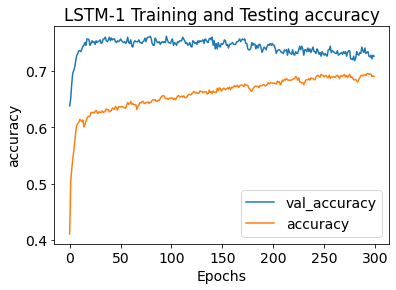

In [32]:
f = pyplot.figure()
pyplot.plot(history.history['val_accuracy'], label='val_accuracy')
pyplot.plot(history.history['accuracy'], label='accuracy')
pyplot.legend()
pyplot.xlabel('Epochs')
pyplot.ylabel('accuracy')
pyplot.title('LSTM-1 Training and Testing accuracy')
pyplot.savefig('LSTM/lstm-1-acc.png')
pyplot.show()
now = datetime.datetime.now()

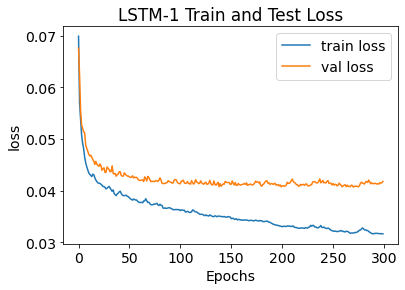

In [33]:
f1 = pyplot.figure()
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='val loss')
pyplot.legend()
pyplot.xlabel('Epochs')
pyplot.ylabel('loss')
pyplot.title('LSTM-1 Train and Test Loss')
pyplot.savefig('LSTM/lstm-1-loss.png')
pyplot.show()
now = datetime.datetime.now()


In [34]:
end-start

96.18591904640198

In [35]:
# make a prediction
yhat = model.predict(test_X)

(622, 8)


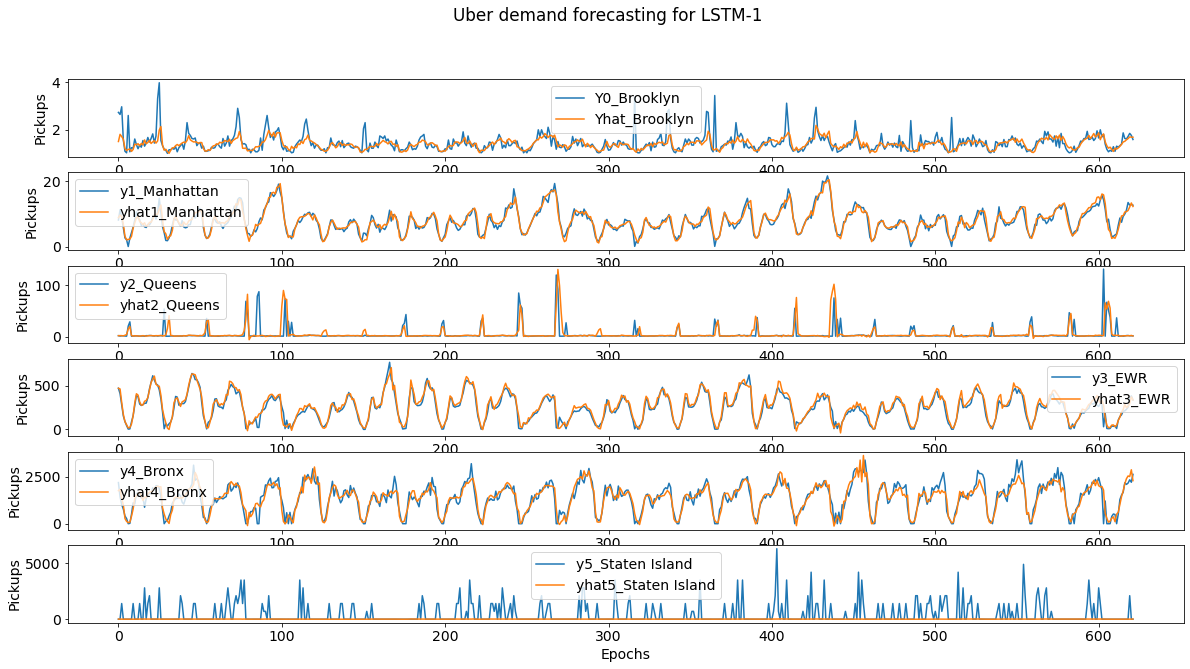

In [36]:
# # {0: 'Bronx', 1: 'Brooklyn', 2: 'EWR', 3: 'Manhattan', 4: 'Queens', 5: 'Staten Island'}
# [1 3 4 2 0 5]
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 48:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,:]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), N))
inv_y = np.concatenate((test_y, test_X[:, 48:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:]
print(inv_y.shape)
f3 = pyplot.figure(figsize=(20,10))
pyplot.subplot(6, 1, 1)
pyplot.plot(inv_y[:,0],label='Y0_Brooklyn')
pyplot.plot(inv_yhat[:,0],label='Yhat_Brooklyn')
pyplot.xlabel("Epochs")
pyplot.ylabel("Pickups")
pyplot.legend()

pyplot.subplot(6, 1, 2)
pyplot.plot(inv_y[:,1],label='y1_Manhattan')
pyplot.plot(inv_yhat[:,1],label='yhat1_Manhattan')
pyplot.xlabel("Epochs")
pyplot.ylabel("Pickups")
pyplot.legend()

pyplot.subplot(6, 1, 3)
pyplot.plot(inv_y[:,2],label='y2_Queens')
pyplot.plot(inv_yhat[:,2],label='yhat2_Queens')
pyplot.xlabel("Epochs")
pyplot.ylabel("Pickups")
pyplot.legend()

pyplot.subplot(6, 1, 4)
pyplot.plot(inv_y[:,3],label='y3_EWR')
pyplot.plot(inv_yhat[:,3],label='yhat3_EWR')
pyplot.xlabel("Epochs")
pyplot.ylabel("Pickups")
pyplot.legend()

pyplot.subplot(6, 1, 5)
pyplot.plot(inv_y[:,4],label='y4_Bronx')
pyplot.plot(inv_yhat[:,4],label='yhat4_Bronx')
pyplot.xlabel("Epochs")
pyplot.ylabel("Pickups")
pyplot.legend()

pyplot.subplot(6, 1, 6)
pyplot.plot(inv_y[:,5],label='y5_Staten Island')
pyplot.plot(inv_yhat[:,5],label='yhat5_Staten Island')
pyplot.xlabel("Epochs")
pyplot.ylabel("Pickups")
pyplot.legend()
f3.suptitle('Uber demand forecasting for LSTM-1')

pyplot.savefig('LSTM/LSTM-1_forecast.png')
pyplot.show()
now = datetime.datetime.now()


In [37]:
# calculate RMSE
import math
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 371.439
